In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hbar = 1.055e-34 # (J / Hz) = (kg * m^2 / s)
c = 3e8
kb = 1.38e-23
SI2ev = (1 / 1.6e-19) * c

rho = 2200
R = 166e-9 / 2
v = (4/3) * np.pi * R**3
m = v * rho

epsilon = 1.45**2
na = 0.77
lambd = 1064e-9
k = 2 * np.pi / lambd
omega_rayleigh = 2.8 * lambd / (np.pi * na**2)  # 2.8 is a correction to paraxial

In [5]:
def get_c_d_integrals(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    
    return C, D

def calc_geometric_factor(na):
    """Calculate the geometric factor A using Eq. (A3)(, E2a) and (E2b) of https://arxiv.org/pdf/1907.12838.pdf"""
    C, D = get_c_d_integrals(na)
    return D / C

A = calc_geometric_factor(na)

In [6]:
na=0.77
omegaz = 2 * np.pi * 80000
p0 = (omegaz**2 * (2.8**4)) / ((24/(np.pi * c * rho)) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2)
p_sca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0

In [7]:
print(fr'Power at focus = {p0*1000} mW, predicted z frequency : (2 pi) {omegaz / 2 / np.pi / 1000:.2f} kHz')
print(f'Power scattered by the sphere = {p_sca * 1e6:2f} uW')

Power at focus = 315.1715911049573 mW, predicted z frequency : (2 pi) 80.00 kHz
Power scattered by the sphere = 2.096274 uW


In [8]:
def get_thermal_damping(p):
    # Pressure `p` in mbar
    p_pascal = p * 100

    r = 166e-9 / 2
    R = 83144    # gas constant; J / (mol K)
    v_gas = np.sqrt(8 * R * 300 / 4e-3)
    
    return (64/3) * (r**2 * p_pascal / (m * v_gas))

def get_photon_damping(omegaz):
    p0 = (omegaz**2 * (2.8**4)) / ((24/(np.pi * c * rho)) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2)
    psca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0
    
    return 2 * (A**2 + 2/5) * psca / (m * c**2)

In [9]:
def calc_damping(omegaz, p):
    p0 = (omegaz**2 * (2.8**4)) / ((24/(np.pi * c * rho)) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2)
    psca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0
    
    damping_photon = 2 * (A**2 + 2/5) * psca / (m * c**2)
    damping_thermal = get_thermal_damping(p)
    
    return damping_thermal, damping_photon

In [10]:
def calc_momentum_sensitivity(omegaz, p, eta=0.55):
    # Photon recoil damping and backaction force spectrum
    p0 = (omegaz**2 * (2.8**4)) / ((24/(np.pi * c * rho)) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2)
    psca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0
    
    damping_photon = 2 * (A**2 + 2/5) * psca / (m * c**2)
    S_ff_ba = (A**2 + 2/5) * hbar * k * psca / c
    
    # Imprecision spectrum
    S_zz_imp = (1/eta) * (1 / (A**2 + 2/5)) * hbar * c / (4 * k * psca)
    
    # Thermal force spectrum
    damping_thermal = get_thermal_damping(p)
    S_ff_th =  4 * m * kb * 300 * damping_thermal
    
    # A vector for integration
    omega_integral = np.linspace(-2*np.pi*500000, 2*np.pi*500000, 5000)
    
    damping_total = damping_photon + damping_thermal
    chi = (1 / m) / (omegaz**2 - omega_integral**2 - damping_total * omega_integral * 1j) # Complex susceptibility

    integrand = np.abs(chi)**2 / (S_zz_imp + np.abs(chi)**2 * (S_ff_ba + S_ff_th))
    integral = np.trapz(integrand, omega_integral)
    
    delta_p = np.sqrt(2 * np.pi / integral)
    
    # keV/c
    return (delta_p * SI2ev / 1000)

In [13]:
pp = np.logspace(-12, -6, 250)
zz = np.linspace(10000*2*np.pi, 200000*2*np.pi, 250)

ppv, zzv = np.meshgrid(pp, zz)
dp = np.empty_like(ppv)
for i, p in enumerate(pp):
    for j, omegaz in enumerate(zz):
        dp[i, j] = calc_momentum_sensitivity(omegaz, p, 0.55)

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_4858/1467905003.py:5: SyntaxWarning: invalid escape sequence '\D'
  ax.text(0.4e-8, 55, f"$\Delta p$ = {calc_momentum_sensitivity(80000*2*np.pi, 2e-8, 0.55):.1f} keV/c", color='r', fontsize=16)


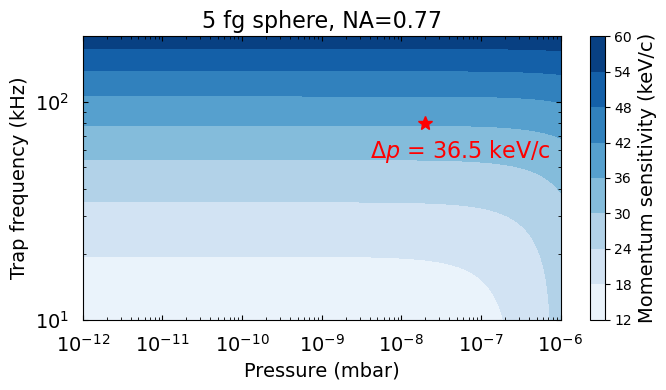

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))

im = ax.contourf(pp, zz/(2*np.pi*1000), dp.T, cmap=plt.cm.Blues)
ax.plot(2e-8, 80, 'r*', markersize=10)
ax.text(0.4e-8, 55, f"$\Delta p$ = {calc_momentum_sensitivity(80000*2*np.pi, 2e-8, 0.55):.1f} keV/c", color='r', fontsize=16)

cb = fig.colorbar(im)
cb.set_label('Momentum sensitivity (keV/c)', fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Pressure (mbar)', fontsize=14)
ax.set_ylabel('Trap frequency (kHz)', fontsize=14)
ax.set_title('5 fg sphere, NA=0.77', fontsize=16)

# ax.tick_params(direction='in', right=True, top=True, labelright=False, labeltop=False,rotation=0)
ax.xaxis.set_tick_params(direction='in', which='both', right=True, labelsize=14, pad=10)
ax.yaxis.set_tick_params(direction='in', which='both', top=True, labelsize=14, pad=10)
fig.tight_layout()

# plt.savefig('momentum_sensitivity.png', format='png', transparent=True, dpi=400)

In [11]:
damping_thermal, damping_photon = np.empty_like(pp), np.empty_like(pp)
for i, p in enumerate(pp):
    damping_thermal[i], damping_photon[i] = calc_damping(80000*2*np.pi, p)

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32474/1582251065.py:7: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel('$\gamma_{\mathrm{photon}} / \gamma_{\mathrm{gas}}$', fontsize=14)


Text(0, 0.5, '$\\gamma_{\\mathrm{photon}} / \\gamma_{\\mathrm{gas}}$')

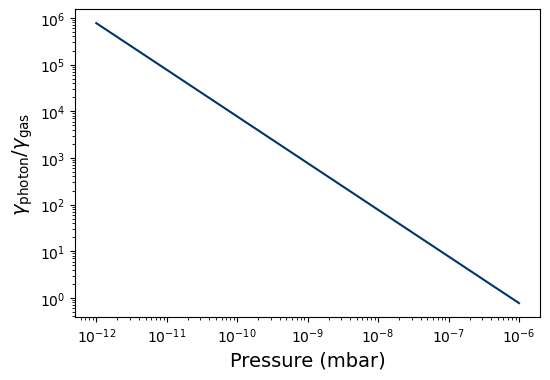

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(pp, damping_photon/damping_thermal, color='#00356b')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Pressure (mbar)', fontsize=14)
ax.set_ylabel('$\gamma_{\mathrm{photon}} / \gamma_{\mathrm{gas}}$', fontsize=14)

## Plot the displacement noise and force noise

In [13]:
# Make an array of freuqencies
omega = np.linspace(0, 2*300e3*np.pi, 10000)

In [16]:
pi = np.pi
Omega_0 = 2 * pi * 100 * 1000  # Resonant frequency (Hz)
zpf = np.sqrt(hbar / (2 * m * Omega_0))                      # Zero point fluctuation (m)

omegaz = Omega_0
p0 = (omegaz**2 * (2.8**4)) / ((24/(np.pi * c * rho)) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2)
psca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0

# Backaction
damping_photon = 2 * (A**2 + 2/5) * psca / (m * c**2)
S_ff_ba = (A**2 + 2/5) * hbar * k * psca / c

# Imprecision spectrum
eta = 1
S_zz_imp = (1/eta) * (1 / (A**2 + 2/5)) * hbar * c / (4 * k * psca)

# gamma = damping_photon * 1e8
gamma = 250 * 2 * np.pi

# ZPF
S_zz_zpf = 0.5 * zpf**2 * gamma / ( (omega-Omega_0)**2 + (gamma/2)**2 )

chi = (1 / m) / (Omega_0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility

S_zz_tot = np.full_like(omega, S_zz_imp) + S_ff_ba * np.abs(chi) * np.abs(chi) + S_zz_zpf

print(f'Imprecison noise: {S_zz_imp:.2e} m$^2$/Hz')

Imprecison noise: 3.75e-28 m$^2$/Hz


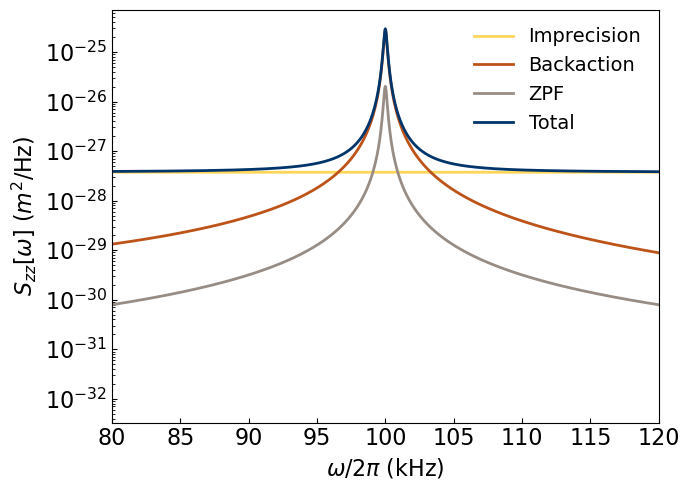

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(omega/(1000*2*pi), np.full_like(omega, S_zz_imp), label='Imprecision', color='#ffd55a', linewidth=2)
ax.plot(omega/(1000*2*pi), S_ff_ba * np.abs(chi) * np.abs(chi), label='Backaction', color='#bd5319', linewidth=2)
ax.plot(omega/(1000*2*pi), S_zz_zpf, label='ZPF', color='#978d85', linewidth=2)
ax.plot(omega/(1000*2*pi), S_zz_tot, label='Total', alpha=1, color='#00356b', linewidth=2)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlim(80, 120)
ax.set_yscale('log')
ax.set_xlabel(r'$\omega / 2 \pi$ (kHz)', fontsize=16)
ax.set_ylabel(r'$S_{zz}[\omega]$ ($m^2$/Hz)', fontsize=16)
ax.legend(frameon=False, fontsize=14)

plt.tight_layout()
# plt.savefig('/Users/yuhan/work/nanospheres/figures/displacement_noise.png', format='png', transparent=True, dpi=600)

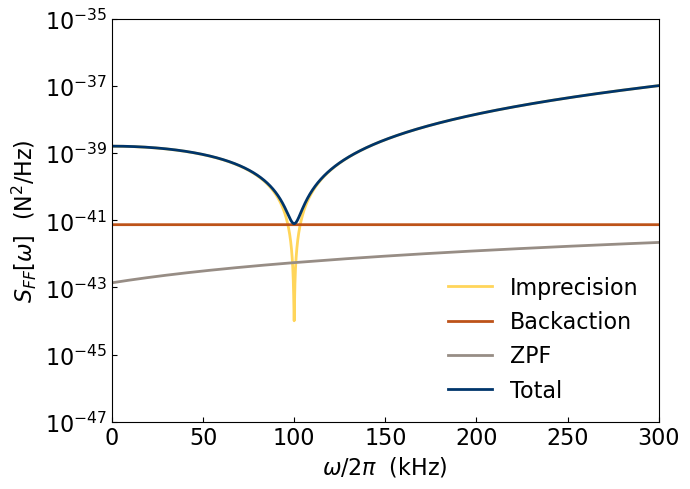

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))

S_ff_imp = S_zz_imp / (np.abs(chi) * np.abs(chi))
S_ff_bac = np.full_like(omega, S_ff_ba)
S_ff_zpf = S_zz_zpf / (np.abs(chi) * np.abs(chi))

ax.plot(omega/(1000*2*pi), S_ff_imp, label='Imprecision', linewidth=2, color='#ffd55a')
ax.plot(omega/(1000*2*pi), S_ff_bac, label='Backaction', linewidth=2, color='#bd5319')
ax.plot(omega/(1000*2*pi), S_ff_zpf, label='ZPF', linewidth=2, color='#978d85')
ax.plot(omega/(1000*2*pi),  S_ff_imp + S_ff_bac + S_ff_zpf, label='Total', linewidth=2, color='#00356b')

ax.set_yscale('log')
ax.set_xlabel(r'$\omega / 2 \pi$  (kHz)', fontsize=16)
ax.set_ylabel(r'$S_{FF}[\omega] \ \ $($\mathrm{N}^2/\mathrm{Hz}$)', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)

ax.set_xlim(0, 300)
ax.set_ylim(1e-47, 1e-35)
ax.legend(frameon=False, fontsize=16, loc='lower right')

plt.tight_layout()
plt.savefig('/Users/yuhan/work/nanospheres/figures/force_noise.png', format='png', transparent=True, dpi=600)